This will try to parse resumes using OCR and fragmentation by blocks.
First step is to define to target data structure

In [12]:
from dataclasses import dataclass, field, fields
from typing import List, Optional

@dataclass
class Resume:
    name         : Optional[str]  = None
    email        : Optional[str]  = None
    phone        : Optional[str]  = None
    education    : List           = field(default_factory=list)
    experience   : List           = field(default_factory=list)
    skills       : List           = field(default_factory=list)
    introduction : Optional[str]  = None
    technologies : List           = field(default_factory=list)
    hyperlinks   : List           = field(default_factory=list)


# Constantes para mostrar una seccion y elegir un CV
CV_NUMBER        = 4
SHOWCASE_SECTION = 7


Enumerate the available resumes

Loading 'CV_Ernesto_FullStack_Developer.pdf'
→ 3 pages


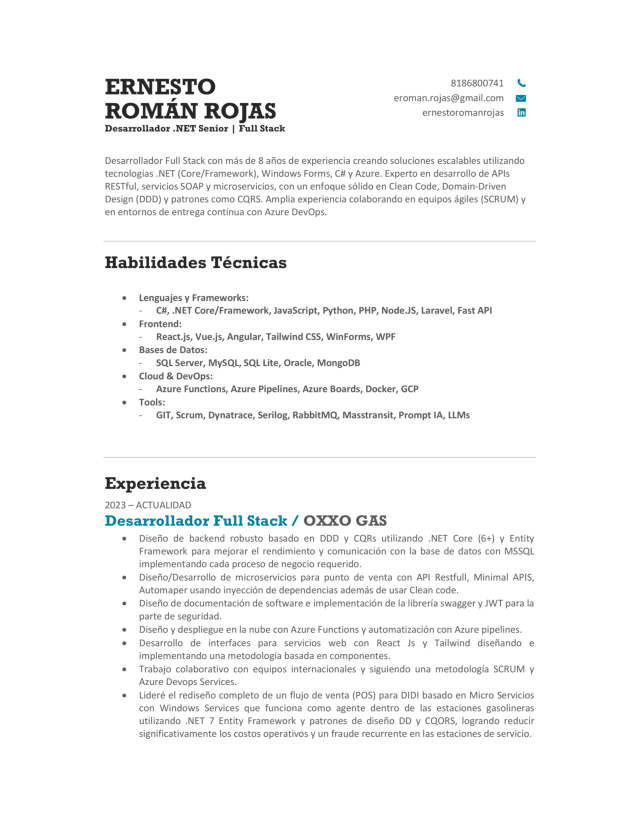

In [13]:
import os
import io
import PyPDF2
import matplotlib.pyplot as plt
from pdf2image import convert_from_bytes

POPPLER_PATH = (
    r"C:\ProgramData\chocolatey\lib\poppler-24.08.0\Library\bin"
)
# 1) locate the first PDF
resumes_dir = os.path.join(os.getcwd(), "resumes")
files = os.listdir(resumes_dir)
pdf_files = [f for f in files if f.lower().endswith(".pdf")]

if not pdf_files:
    raise RuntimeError("No PDF found in resumes/")

first_pdf = pdf_files[CV_NUMBER]
file_path = os.path.join(resumes_dir, first_pdf)
print(f"Loading {first_pdf!r}")

# 2) read its bytes and load into PyPDF2
with open(file_path, "rb") as f:
    pdf_bytes = f.read()

pdf_reader = PyPDF2.PdfReader(io.BytesIO(pdf_bytes))
print(f"→ {len(pdf_reader.pages)} pages")

# 3) convert only page 1 to a PIL.Image
images = convert_from_bytes(
    pdf_bytes,
    dpi=450,
    first_page=1,
    last_page=1,
    poppler_path=POPPLER_PATH
)
img = images[0]  # PIL.Image

# 4) display inline in Jupyter
plt.figure(figsize=(8, 11))
plt.imshow(img)
plt.axis("off")
plt.show()

Work in a single file

Found 13 sections:
  col 0, row 0: start=(0,0), width=294px, height=2475px
  col 0, row 1: start=(0,2475), width=294px, height=2475px
  col 1, row 0: start=(294,0), width=3234px, height=215px
  col 1, row 1: start=(294,215), width=3234px, height=618px
  col 1, row 2: start=(294,833), width=3234px, height=565px
  col 1, row 3: start=(294,1398), width=3234px, height=280px
  col 1, row 4: start=(294,1678), width=3234px, height=1031px
  col 1, row 5: start=(294,2709), width=3234px, height=299px
  col 1, row 6: start=(294,3008), width=3234px, height=204px
  col 1, row 7: start=(294,3212), width=3234px, height=1506px
  col 1, row 8: start=(294,4718), width=3234px, height=232px
  col 2, row 0: start=(3528,0), width=297px, height=2475px
  col 2, row 1: start=(3528,2475), width=297px, height=2475px


(np.float64(-0.5), np.float64(3824.5), np.float64(4949.5), np.float64(-0.5))

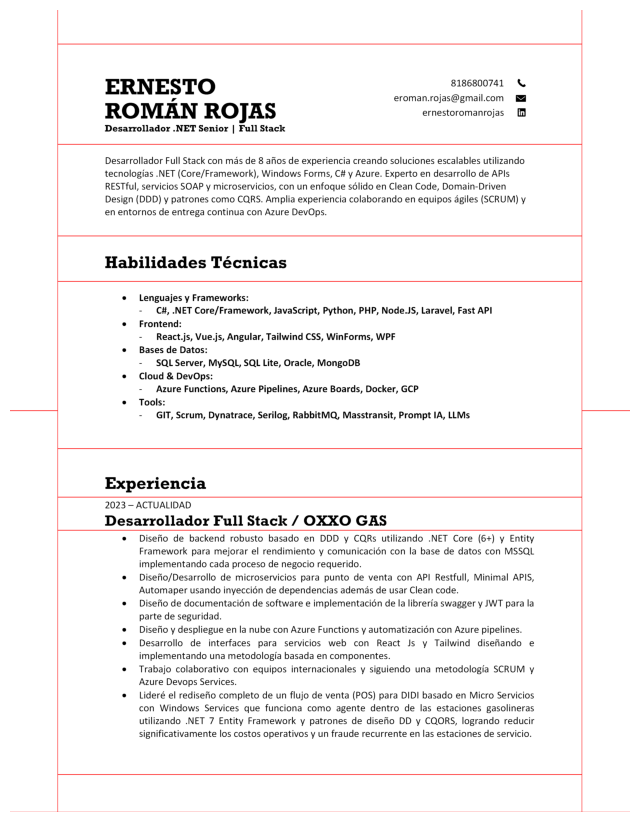

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

# assume `img` is your original PIL page‐image

# --- 0) PREPROCESSING: grayscale → binarize so text is black, background white ---
gray_arr = np.array(img.convert("L"))
thresh = 128
# ink mask: True where text (dark)
ink = gray_arr < thresh
# build a display image: 0=black text, 255=white bg
bin_arr = np.where(ink, 0, 255).astype("uint8")
# replace img with the binarized version (RGB so we can draw red lines)
img = Image.fromarray(bin_arr, mode="L").convert("RGB")

# now `ink` is the same mask you’ll use below, and `img` is pure b/w for drawing
w, h = img.size

# 1) binary ink mask
# (we already have `ink` from above, so you can drop the old gray<250 line)

# 2) detect vertical splits
col_sums = ink.sum(axis=0)
min_v_gap = 50
v_thresh = h * 0.01
v_splits = []
x = 0
while x < w:
    if col_sums[x] < v_thresh:
        start = x
        while x < w and col_sums[x] < v_thresh:
            x += 1
        end = x
        if (end - start) >= min_v_gap:
            v_splits.append((start + end)//2)
    else:
        x += 1

# 3) define column dividers
x_divs = [0] + v_splits + [w]

# 4) find horizontal splits per column
min_h_gap = 50
h_splits_by_col = []
for x0, x1 in zip(x_divs[:-1], x_divs[1:]):
    sub = ink[:, x0:x1]
    row_sums = sub.sum(axis=1)
    h_thresh = (x1 - x0) * 0.01

    ys = []
    y = 0
    while y < h:
        if row_sums[y] < h_thresh:
            start = y
            while y < h and row_sums[y] < h_thresh:
                y += 1
            end = y
            if (end - start) >= min_h_gap:
                ys.append((start + end)//2)
        else:
            y += 1

    h_splits_by_col.append(ys)

# 5) draw the splits and collect rect info
out = img.copy()
draw = ImageDraw.Draw(out)
for x in v_splits:
    draw.line([(x, 0), (x, h)], fill="red", width=3)

sections = []
for ci, (x0, x1) in enumerate(zip(x_divs[:-1], x_divs[1:])):
    y_divs = [0] + h_splits_by_col[ci] + [h]
    for ri, (y0, y1) in enumerate(zip(y_divs[:-1], y_divs[1:])):
        draw.line([(x0, y1), (x1, y1)], fill="red", width=4)
        width = x1 - x0
        height = y1 - y0
        sections.append((ci, ri, x0, y0, width, height))

# 6) print each section’s top-left and size
print(f"Found {len(sections)} sections:")
for ci, ri, x0, y0, w0, h0 in sections:
    print(f"  col {ci}, row {ri}: start=({x0},{y0}), "
          f"width={w0}px, height={h0}px")
   
# 7) display the image
plt.figure(figsize=(8, 11))
plt.imshow(out)
plt.axis("off")

For each sections we can apply OCR algorithm

Text(0.5, 1.0, 'Full page with selected section highlighted')

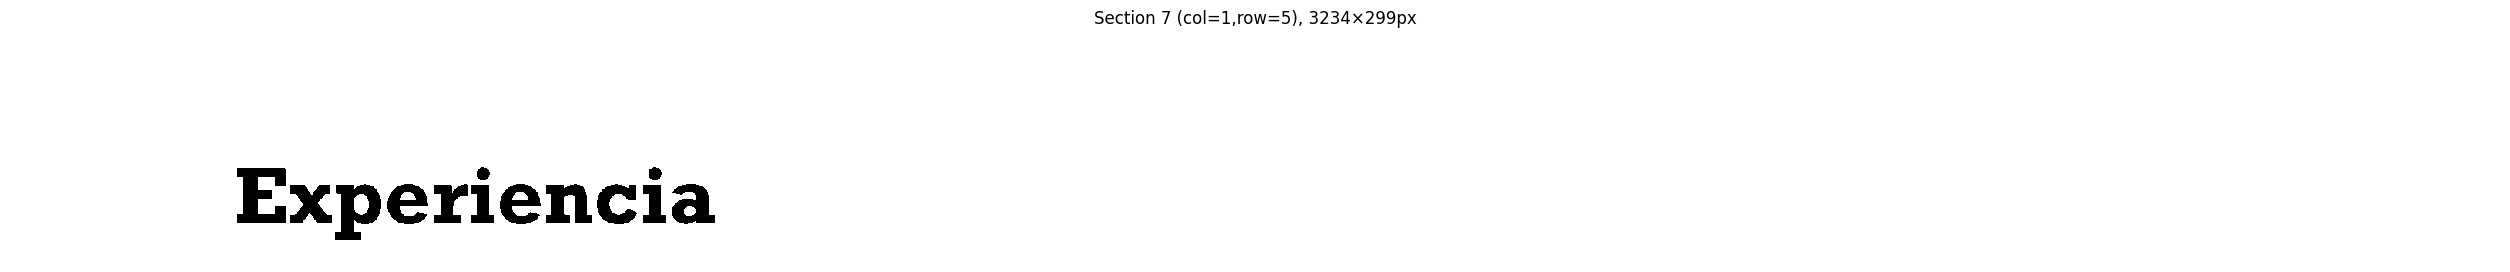

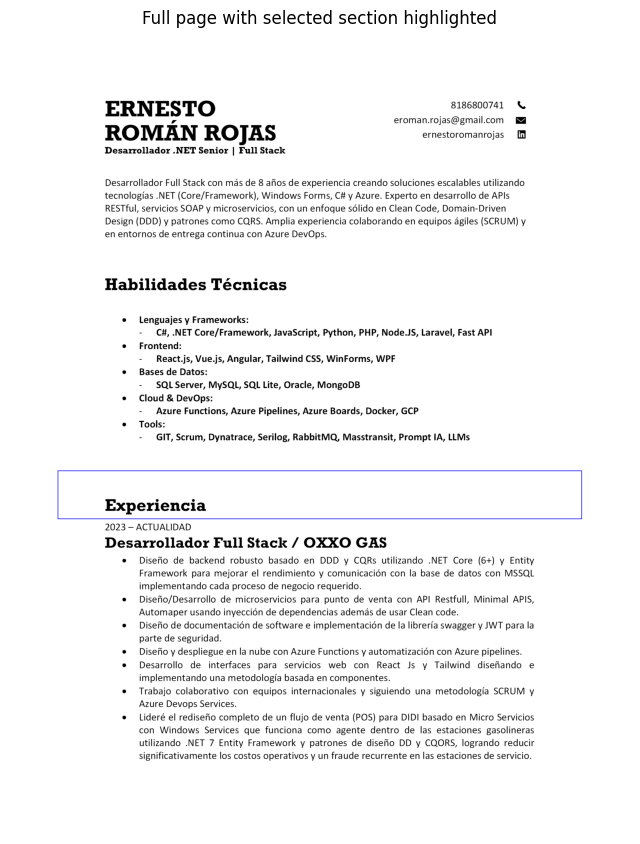

In [15]:
from PIL import ImageDraw
import matplotlib.pyplot as plt

# 1) Build a list of all section images
section_imgs = []
for idx, (ci, ri, x0, y0, w0, h0) in enumerate(sections):
    sec = img.crop((x0, y0, x0 + w0, y0 + h0))
    section_imgs.append(sec)

# 3) Choose which one to display
section_idx = SHOWCASE_SECTION
ci, ri, x0, y0, w0, h0 = sections[section_idx]

# 4) Grab it from the array
sec_img = section_imgs[section_idx]

# 5) Display at full (native) resolution
dpi = plt.rcParams['figure.dpi']
figsize = (w0 / dpi, h0 / dpi)
plt.figure(figsize=figsize, dpi=dpi)
plt.imshow(sec_img, interpolation='nearest')
plt.axis('off')
plt.title(f"Section {section_idx} "
          f"(col={ci},row={ri}), {w0}×{h0}px")

# 6) (Optional) Show full page with that region highlighted
out2 = img.copy()
draw2 = ImageDraw.Draw(out2)
draw2.rectangle(
    [(x0, y0), (x0 + w0, y0 + h0)],
    outline="blue",
    width=4
)
plt.figure(figsize=(8, 11))
plt.imshow(out2)
plt.axis("off")
plt.title("Full page with selected section highlighted")

Por cada sección se va a extraer el texto a travez de Tesseract 

In [16]:
# Array de imágenes PIL.Image.Image
import pytesseract

pytesseract.pytesseract.tesseract_cmd = (
    r"C:\Program Files\Tesseract-OCR\tesseract.exe"
)

# Filtrar section_imgs para quedarnos solo con las que tienen texto
filtered = []
for sec in section_imgs:
    text = pytesseract.image_to_string(sec, lang="eng+spa")
    if text.strip():
        filtered.append((sec, text))

# Sobrescribimos section_imgs con sólo las imágenes no vacías
section_imgs = [sec for sec, _ in filtered]
text_sections = [txt for _, txt in filtered]

# Imprimir índice y primeros 50 caracteres de cada texto detectado
for i, text in enumerate(text_sections):
    snippet = text.strip().replace("\n", " ")
    print(f"{i}: {snippet}")

0: ERNESTO 8186800741 ©  eroman.rojas@gmail.com  ROMAN ROJAS ernestoromanrojas ff  Desarrollador .NET Senior | Full Stack
1: Desarrollador Full Stack con mas de 8 afos de experiencia creando soluciones escalables utilizando tecnologias .NET (Core/Framework), Windows Forms, C# y Azure. Experto en desarrollo de APIs RESTful, servicios SOAP y microservicios, con un enfoque solido en Clean Code, Domain-Driven Design (DDD) y patrones como CQRS. Amplia experiencia colaborando en equipos agiles (SCRUM) y en entornos de entrega continua con Azure DevOps.
2: Habilidades Técnicas
3: Lenguajes y Frameworks:  -  C#, .NET Core/Framework, JavaScript, Python, PHP, Node.JS, Laravel, Fast API Frontend:  -  React.js, Vue.js, Angular, Tailwind CSS, WinForms, WPF  Bases de Datos:  - SQLServer, MySQL, SQL Lite, Oracle, MongoDB  Cloud & DevOps:  - Azure Functions, Azure Pipelines, Azure Boards, Docker, GCP  Tools:  - GIT, Scrum, Dynatrace, Serilog, RabbitMQ, Masstransit, Prompt IA, LLMs
4: Experiencia
5: 20

El texto es extraido perfectamente. Despues de esto podemos revisar img por img que sea correcto.

Desarrollador Full Stack con mas de 8 afos de experiencia creando soluciones escalables utilizando
tecnologias .NET (Core/Framework), Windows Forms, C# y Azure. Experto en desarrollo de APIs
RESTful, servicios SOAP y microservicios, con un enfoque solido en Clean Code, Domain-Driven
Design (DDD) y patrones como CQRS. Amplia experiencia colaborando en equipos agiles (SCRUM) y
en entornos de entrega continua con Azure DevOps.


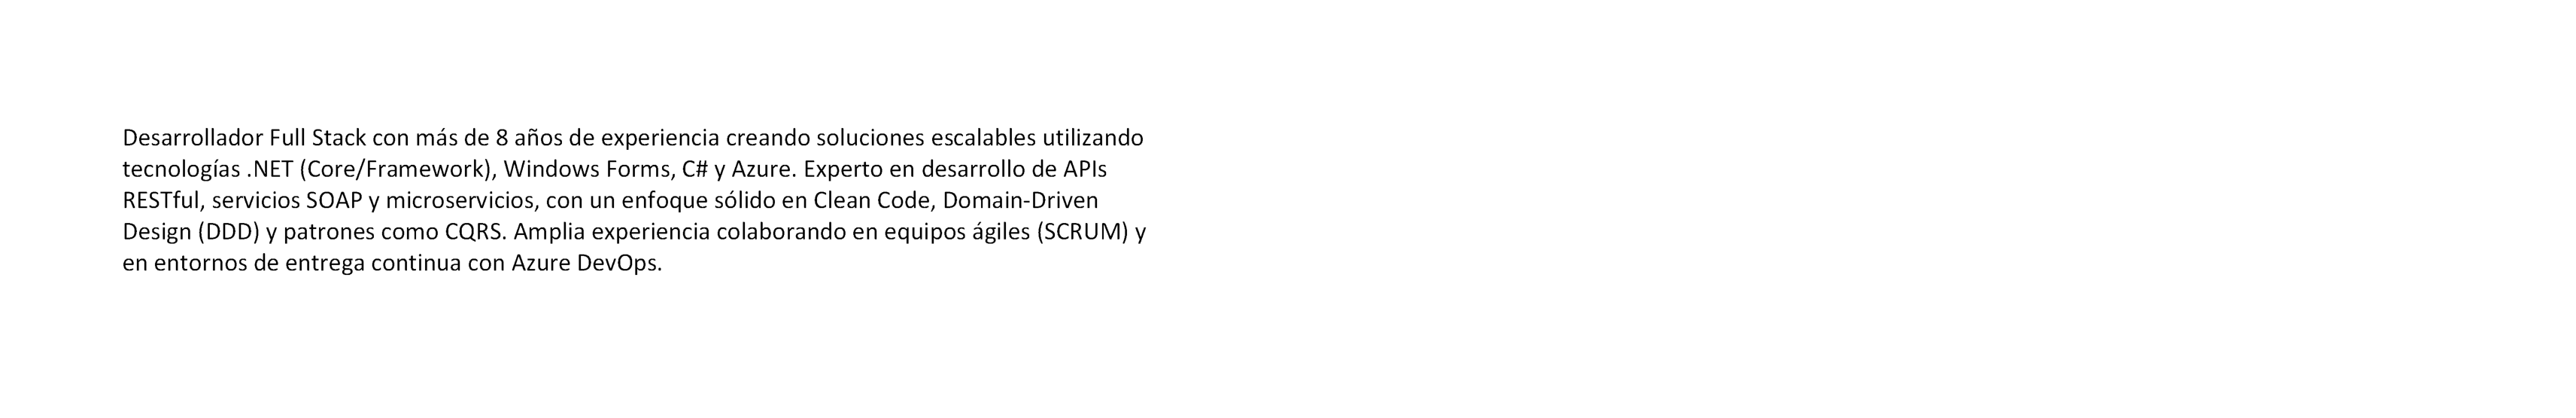

Habilidades Técnicas


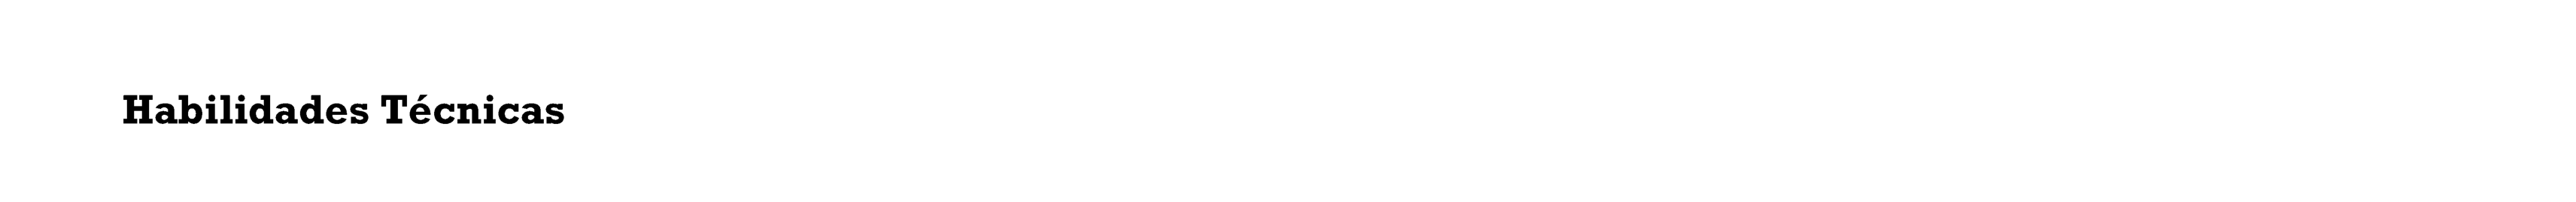

Lenguajes y Frameworks:

-  C#, .NET Core/Framework, JavaScript, Python, PHP, Node.JS, Laravel, Fast API
Frontend:

-  React.js, Vue.js, Angular, Tailwind CSS, WinForms, WPF

Bases de Datos:

- SQLServer, MySQL, SQL Lite, Oracle, MongoDB

Cloud & DevOps:

- Azure Functions, Azure Pipelines, Azure Boards, Docker, GCP

Tools:

- GIT, Scrum, Dynatrace, Serilog, RabbitMQ, Masstransit, Prompt IA, LLMs


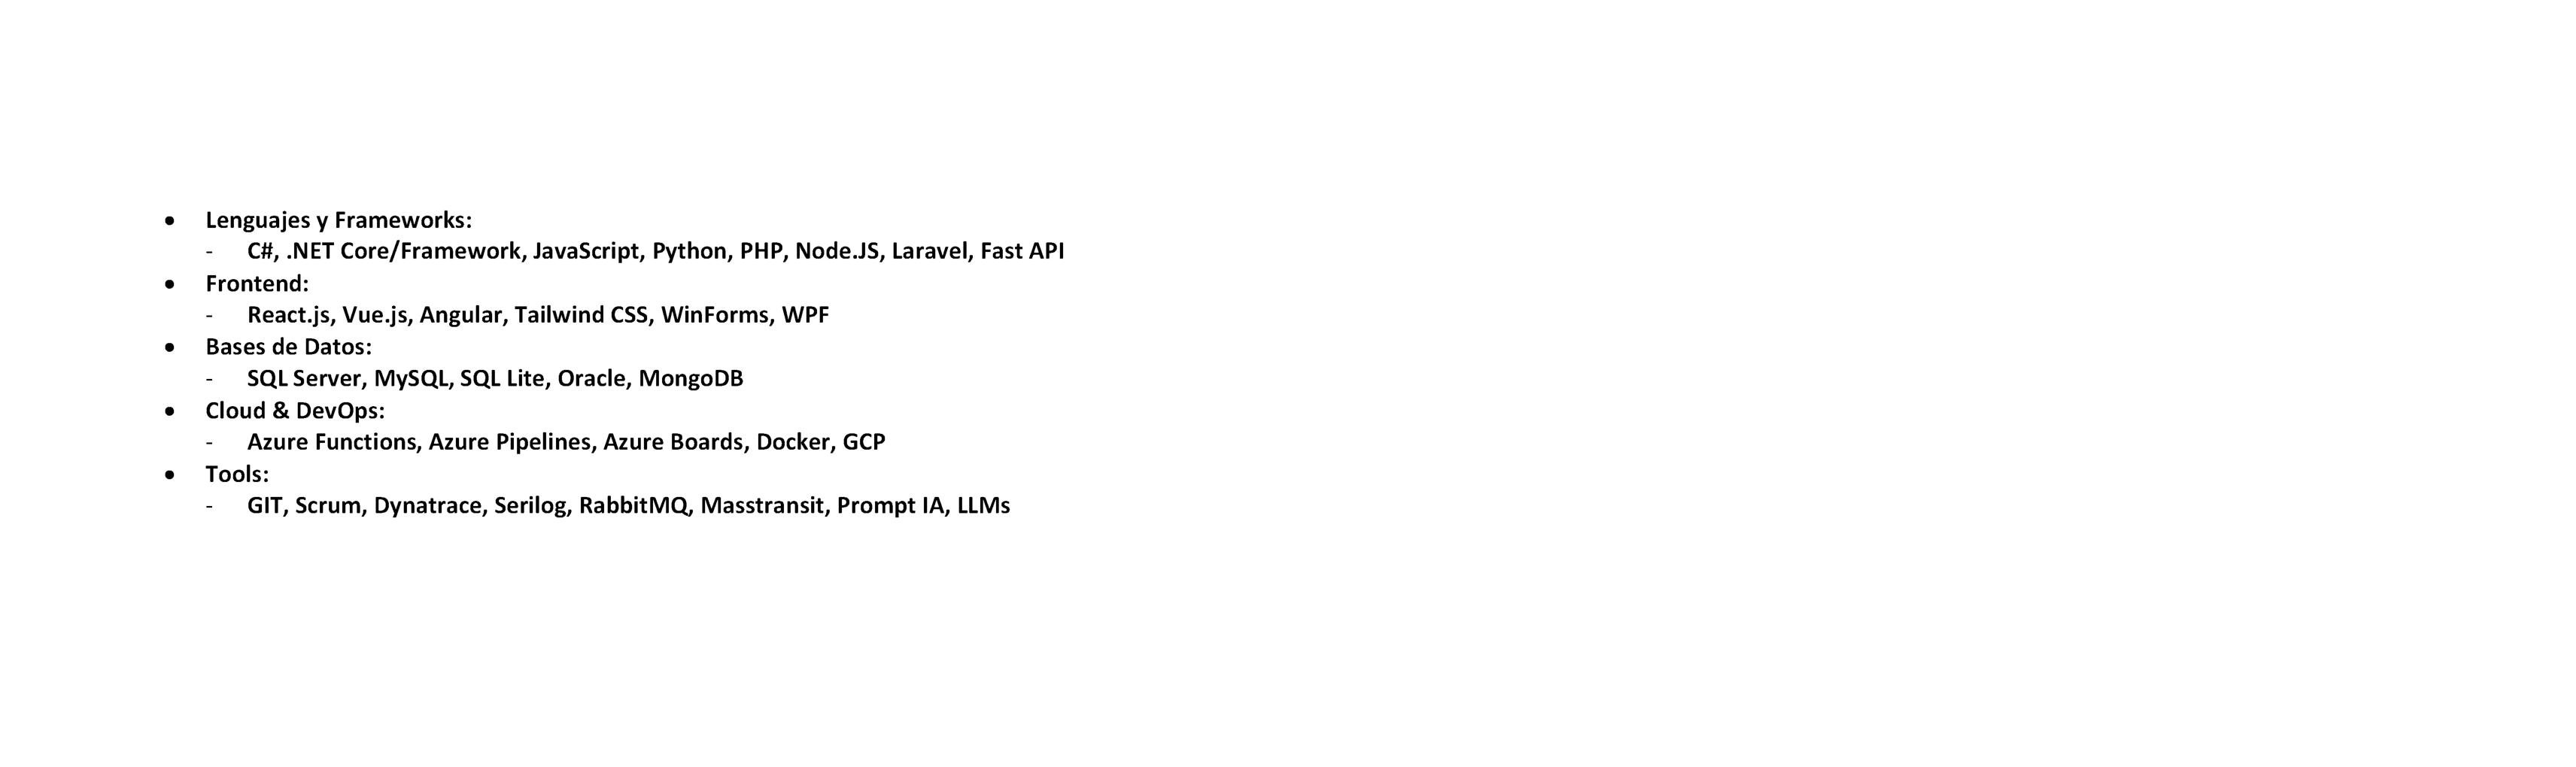

Experiencia


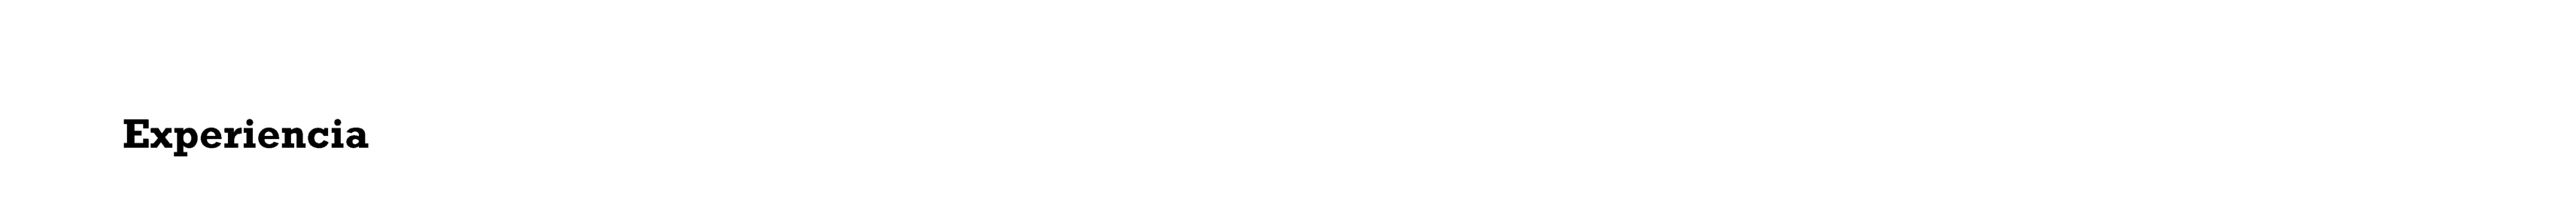

2023 — ACTUALIDAD

Desarrollador Full Stack / OXXO GAS


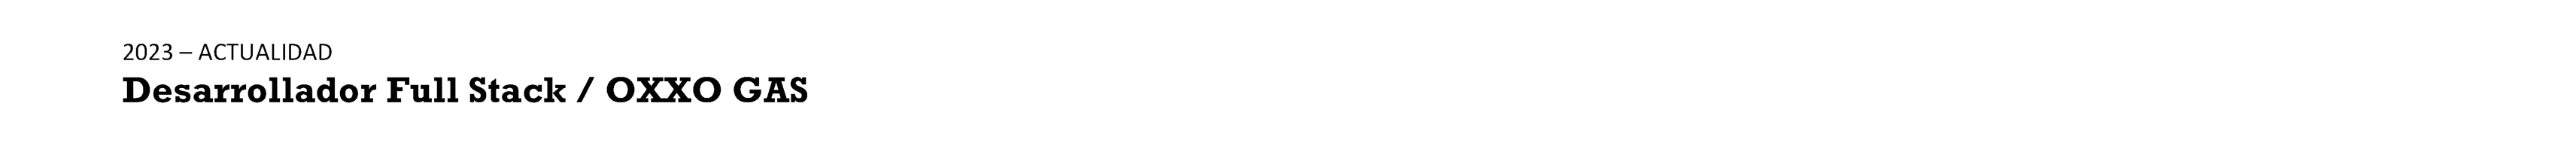

Disefio de backend robusto basado en DDD y CQRs utilizando .NET Core (6+) y Entity
Framework para mejorar el rendimiento y comunicaci6n con la base de datos con MSSQL
implementando cada proceso de negocio requerido.

Disefio/Desarrollo de microservicios para punto de venta con API Restfull, Minimal APIS,
Automaper usando inyeccion de dependencias ademas de usar Clean code.

Disenho de documentacion de software e implementacion de la libreria swagger y JWT para la
parte de seguridad.

Disefno y despliegue en la nube con Azure Functions y automatizacion con Azure pipelines.
Desarrollo de interfaces para servicios web con React Js y Tailwind disehando e
implementando una metodologia basada en componentes.

Trabajo colaborativo con equipos internacionales y siguiendo una metodologia SCRUM y
Azure Devops Services.

Lideré el redisefio completo de un flujo de venta (POS) para DIDI basado en Micro Servicios
con Windows Services que funciona como agente dentro de las estaciones gasolineras
uti

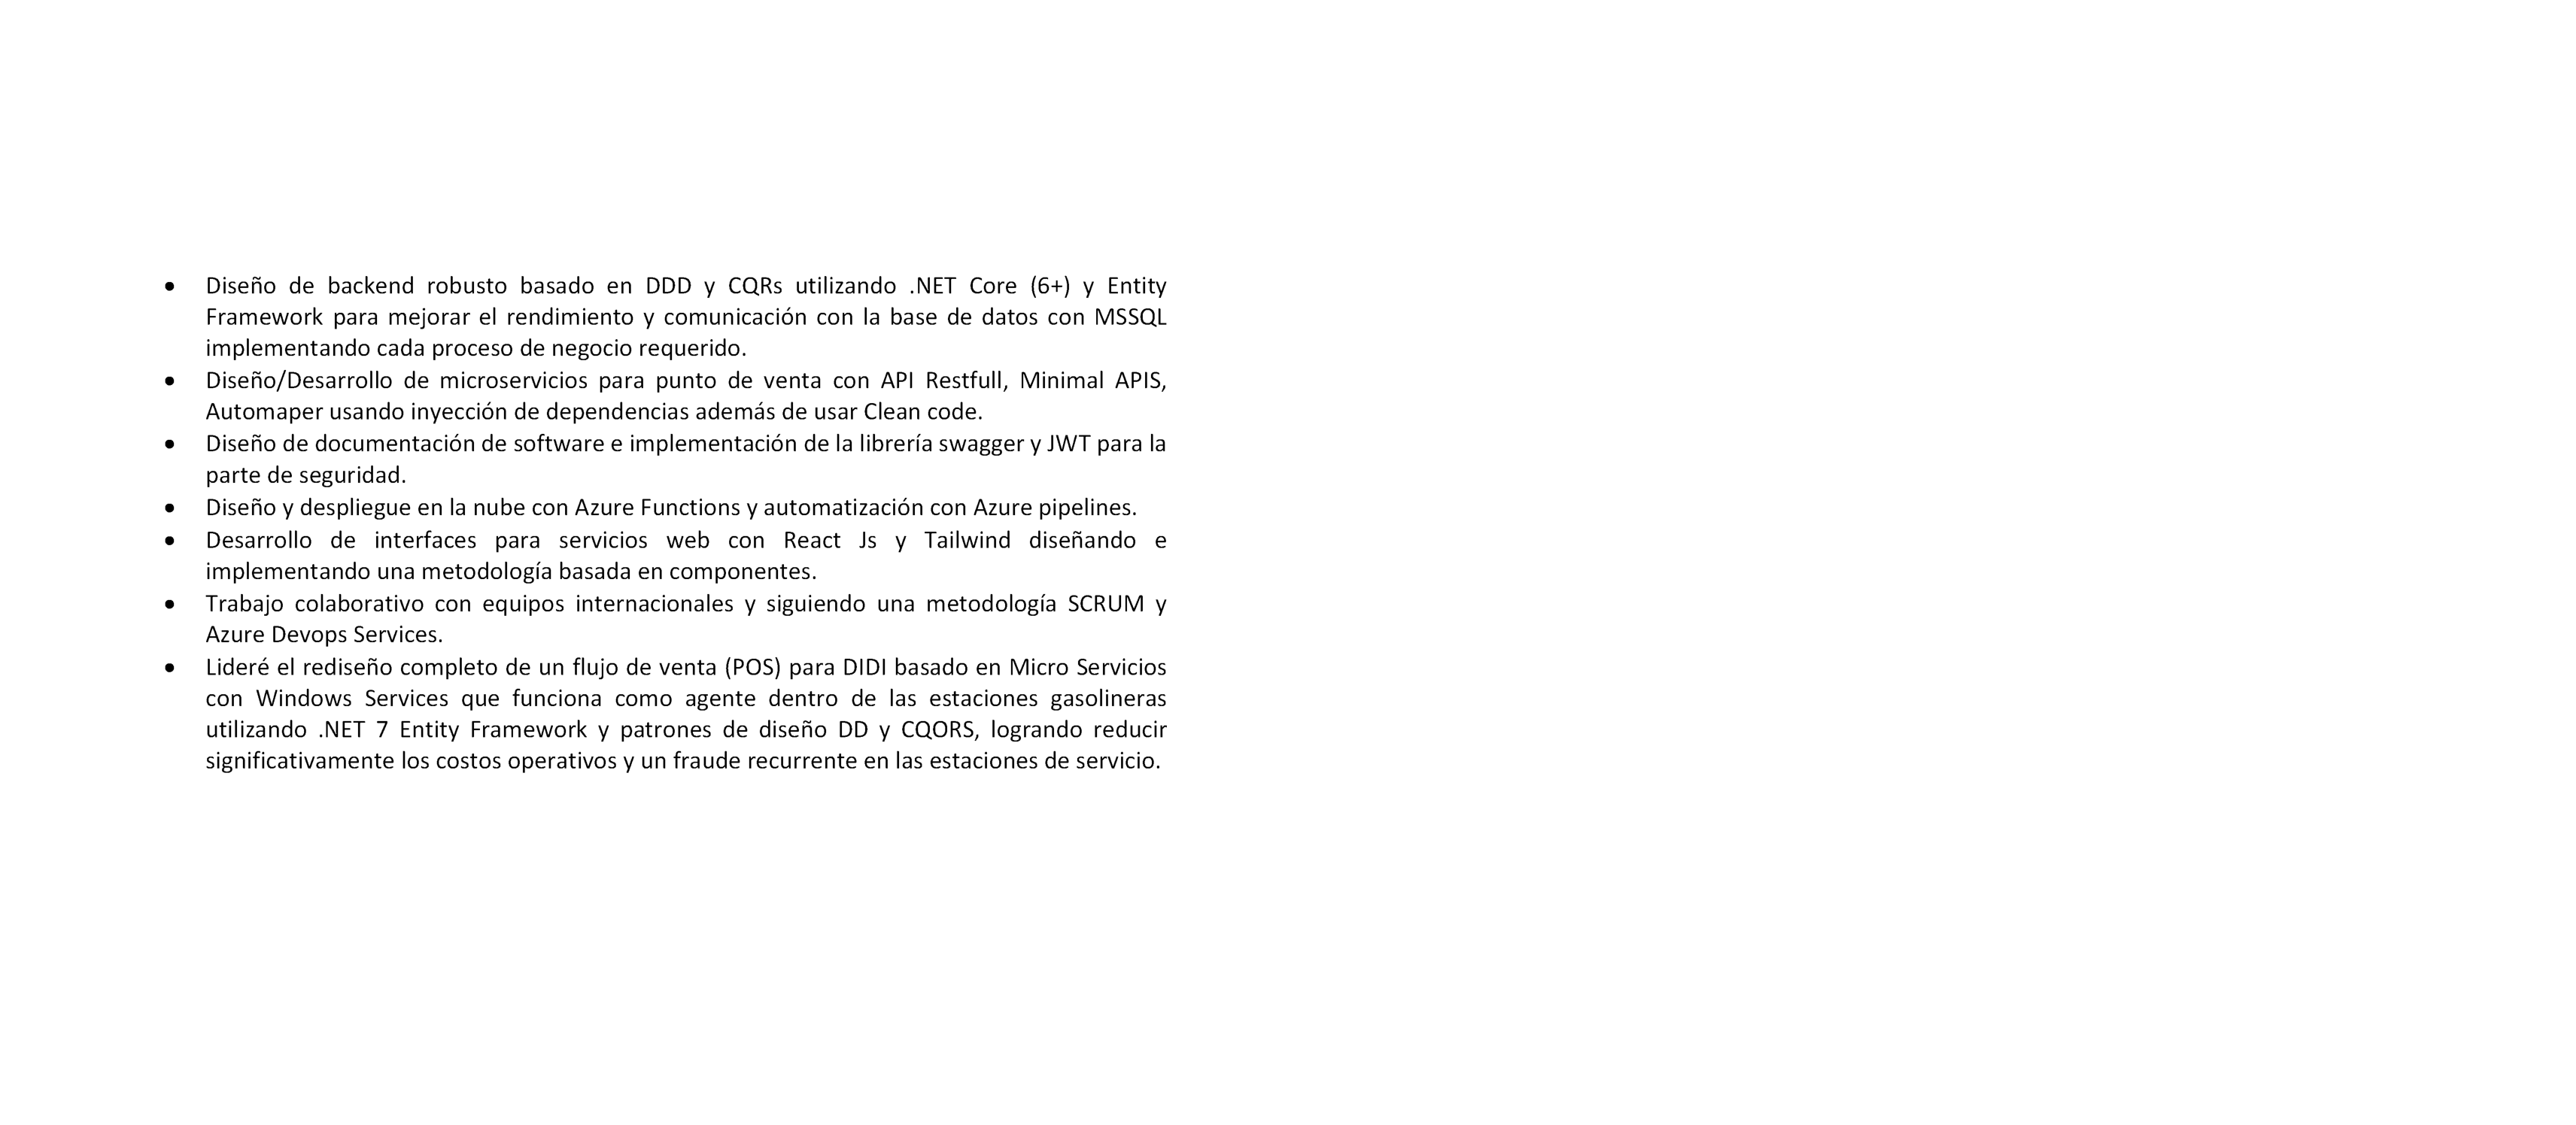

In [17]:
# 2) Define a function to display one filtered section alongside its OCR snippet
def show_section(idx):
    """
    Display the idx-th filtered section image side-by-side with
    its OCR snippet.
    """
    sec_img, text = filtered[idx]
    # Prepare the snippet (first 200 chars, single line)
    snippet = text.strip()
    print(snippet)
    # Compute figure size: width = image_width + text_space, height = image_height
    w, h = sec_img.size
    dpi = plt.rcParams['figure.dpi']
    # Give ~2 inches extra width for the text panel
    figsize = ((w / dpi) + 2, h / dpi)
    
    # Create side-by-side axes
    fig, (ax_img, ax_txt) = plt.subplots(1, 2, figsize=figsize, dpi=dpi)
    
    # Left: the cropped image
    ax_img.imshow(sec_img)
    ax_img.axis('off')
    
    # Right: the text snippet
    ax_txt.axis('off')
    plt.tight_layout()
    plt.show()


# Optional, feel free to select a range of sections to read.
for i in range(len(filtered[1:])):
    show_section(i+1)

Reto: Con el array de text_sections. Es posible llenar la estructura de datos usando NTLK? 

In [18]:
import json


text_sections = [text.replace("\n", " ").lower() for text in text_sections]

print(json.dumps(text_sections, indent=2, ensure_ascii=False))
# Build the resume
resume = Resume()
print(resume)


[
  "ernesto 8186800741 ©  eroman.rojas@gmail.com  roman rojas ernestoromanrojas ff  desarrollador .net senior | full stack ",
  "desarrollador full stack con mas de 8 afos de experiencia creando soluciones escalables utilizando tecnologias .net (core/framework), windows forms, c# y azure. experto en desarrollo de apis restful, servicios soap y microservicios, con un enfoque solido en clean code, domain-driven design (ddd) y patrones como cqrs. amplia experiencia colaborando en equipos agiles (scrum) y en entornos de entrega continua con azure devops. ",
  "habilidades técnicas ",
  "lenguajes y frameworks:  -  c#, .net core/framework, javascript, python, php, node.js, laravel, fast api frontend:  -  react.js, vue.js, angular, tailwind css, winforms, wpf  bases de datos:  - sqlserver, mysql, sql lite, oracle, mongodb  cloud & devops:  - azure functions, azure pipelines, azure boards, docker, gcp  tools:  - git, scrum, dynatrace, serilog, rabbitmq, masstransit, prompt ia, llms ",
  "exp

Con expresiones regulares se puede extraer correo y numero telefonico. El siguiente paso va a ser utilizar NLTK para extraer tecnologías.

In [19]:
from dataclasses import asdict
import spacy

nlp = spacy.load("en_core_web_trf")

def extract_entities(text: str, labels: tuple) -> list[str]:
    doc = nlp(text)
    return [ent.text for ent in doc.ents if ent.label_ in labels]

def extract_emails_and_phones(text: str) -> tuple[list[str], list[str]]:
    doc = nlp(text)
    emails = [token.text for token in doc if token.like_email]
    phones = []
    for token in doc:
        if token.like_num:
            digit_count = sum(char.isdigit() for char in token.text)
            if digit_count >= 7:
                phones.append(token.text)
    return emails, phones

def dedupe_keep_order(seq: list[str]) -> list[str]:
    seen = set()
    out = []
    for x in seq:
        if x not in seen:
            seen.add(x)
            out.append(x)
    return out

all_persons = []
all_orgs    = []
all_gpes    = []
all_dates   = []
all_prods   = []
all_emails  = []
all_phones  = []

for txt in text_sections:
    doc = nlp(txt)
    all_persons.extend(extract_entities(txt, ("PERSON",)))
    all_gpes.extend(extract_entities(txt, ("GPE", "LOC")))
    all_dates.extend(extract_entities(txt, ("DATE",)))
    all_prods.extend(extract_entities(txt, ("PRODUCT",)))

    emails, phones = extract_emails_and_phones(txt)
    all_emails.extend(emails)
    all_phones.extend(phones)

deduped_persons  = dedupe_keep_order(all_persons)
deduped_gpes     = dedupe_keep_order(all_gpes)
deduped_dates    = dedupe_keep_order(all_dates)
deduped_prods    = dedupe_keep_order(all_prods)
deduped_emails   = dedupe_keep_order(all_emails)
deduped_phones   = dedupe_keep_order(all_phones)

if deduped_persons:
    resume.name = deduped_persons[0]

if deduped_emails:
    resume.email = deduped_emails[0]

if deduped_phones:
    resume.phone = deduped_phones[0]

resume.technologies = deduped_prods

print("--- After Extraction ---")
print(f"Name:        {resume.name}")
print(f"Email:       {resume.email}")
print(f"Phone:       {resume.phone}")
print(f"Education:   {resume.education}")
print(f"Technologies:{resume.technologies}")
print("\nFull Resume Object:")
print(json.dumps(asdict(resume), indent=2))

--- After Extraction ---
Name:        None
Email:       eroman.rojas@gmail.com
Phone:       8186800741
Education:   []
Technologies:['windows', 'python', 'php', 'node.js', 'laravel', 'vue.js', 'angular', 'tailwind css', 'winforms', 'sqlserver', 'mysql', 'sql lite', 'oracle', 'mongodb', 'azure', 'docker']

Full Resume Object:
{
  "name": null,
  "email": "eroman.rojas@gmail.com",
  "phone": "8186800741",
  "education": [],
  "experience": [],
  "skills": [],
  "introduction": null,
  "technologies": [
    "windows",
    "python",
    "php",
    "node.js",
    "laravel",
    "vue.js",
    "angular",
    "tailwind css",
    "winforms",
    "sqlserver",
    "mysql",
    "sql lite",
    "oracle",
    "mongodb",
    "azure",
    "docker"
  ],
  "hyperlinks": []
}
